# Time Analysis

   time_limit_s  val_f1_macro  test_f1_macro  val_f1_up  test_f1_up
0            30      0.606080       0.554860   0.437500    0.431213
1            60      0.610521       0.557052   0.447069    0.428326
2           120      0.615580       0.568314   0.452863    0.451265
3           200      0.611224       0.544250   0.449761    0.404672


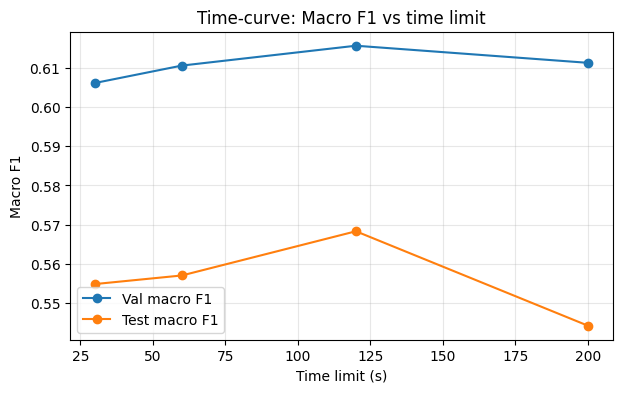

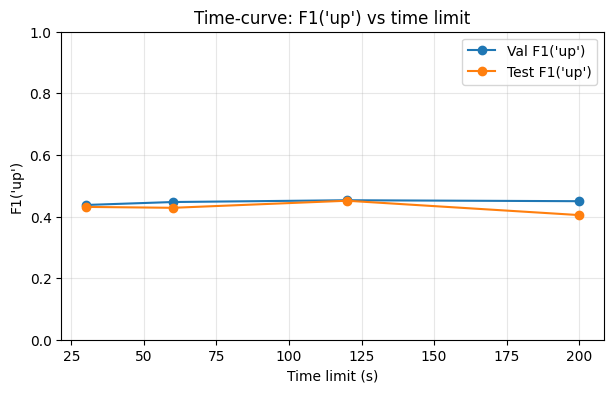

In [1]:
# Time-curve plots: macro F1 and 'up' F1
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

# Robustly resolve repo root

def resolve_repo_root() -> Path:
    try:
        # Prefer REPO_ROOT if notebook already defined it
        if 'REPO_ROOT' in globals():
            p = Path(REPO_ROOT)
            if p.exists():
                return p
    except Exception:
        pass
    # Walk up from CWD looking for markers
    p = Path.cwd()
    for _ in range(6):
        if (p / '.git').exists() or (p / 'upreg_classify').exists():
            return p
        p = p.parent
    return Path.cwd()

REPO_CAND = resolve_repo_root()
# Resolve runs dir whether REPO_CAND is repo root or the package folder
if (REPO_CAND / 'upreg_classify' / 'models').exists():
    RUNS_DIR = REPO_CAND / 'upreg_classify' / 'models' / 'time_curve_runs'
elif (REPO_CAND / 'models').exists():
    RUNS_DIR = REPO_CAND / 'models' / 'time_curve_runs'
else:
    # Fallback relative to notebook
    RUNS_DIR = Path.cwd().parents[1] / 'models' / 'time_curve_runs'


def latest_results_csv(runs_dir: Path = RUNS_DIR) -> Path | None:
    if not runs_dir.exists():
        return None
    csvs = sorted(runs_dir.glob('results_*.csv'), key=lambda p: p.stat().st_mtime, reverse=True)
    return csvs[0] if csvs else None


def parse_up_f1(report_path: Path) -> float | None:
    try:
        if not report_path.exists():
            return None
        txt = report_path.read_text(encoding='utf-8', errors='ignore')
        for line in txt.splitlines():
            s = line.strip()
            # Expect a row like: 'up    0.45    0.30    0.36    1234'
            if s.startswith('up'):
                parts = re.split(r'\s+', s)
                if len(parts) >= 4:
                    try:
                        return float(parts[3])
                    except ValueError:
                        continue
        return None
    except Exception:
        return None


def _guess_label_col(dfp: pd.DataFrame) -> str | None:
    # Exclude index-ish and proba/pred columns
    cols = [c for c in dfp.columns if c not in ['pred', 'Time'] and not str(c).startswith('p_') and not str(c).startswith('Unnamed:')]
    if not cols:
        return None
    # Prefer known label names
    for cand in ['RegClass+4', 'RegClass_plus_4', 'label', 'target']:
        if cand in cols:
            return cand
    # Prefer object dtype (categorical/string)
    obj_cols = [c for c in cols if dfp[c].dtype == 'object']
    if obj_cols:
        # If any contains typical classes, pick it
        for c in obj_cols:
            vals = set(map(str, dfp[c].dropna().unique().tolist()))
            if any(v in vals for v in ['up','down','none']):
                return c
        return obj_cols[0]
    # Else pick the last non-proba column
    return cols[-1]


def up_f1_from_predictions(pred_csv: Path) -> float | None:
    try:
        if not pred_csv.exists():
            return None
        dfp = pd.read_csv(pred_csv)
        col = _guess_label_col(dfp)
        if not col:
            return None
        y_true = dfp[col].astype(str)
        y_pred = dfp['pred'].astype(str)
        return f1_score((y_true == 'up'), (y_pred == 'up'), zero_division=0)
    except Exception:
        return None


def up_f1_from_confusion_matrix(cm_csv: Path) -> float | None:
    try:
        if not cm_csv.exists():
            return None
        cm = pd.read_csv(cm_csv, header=None).astype(float).values
        if cm.shape[0] < 3 or cm.shape[1] < 3:
            return None
        # Assume label order is alphabetical: ['down','none','up']
        up_idx = 2
        tp = cm[up_idx, up_idx]
        fp = cm[:, up_idx].sum() - tp
        fn = cm[up_idx, :].sum() - tp
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        if (prec + rec) == 0:
            return 0.0
        return 2 * prec * rec / (prec + rec)
    except Exception:
        return None


def resolve_output_dir(od_str: str) -> Path:
    # Try as-is
    od = Path(od_str)
    candidates = []
    candidates.append(od)
    # Relative to repo root
    candidates.append(REPO_CAND / od)
    # Relative to repo/upreg_classify
    candidates.append(REPO_CAND / 'upreg_classify' / od)
    # Relative to CWD
    candidates.append(Path.cwd() / od)
    for c in candidates:
        if (c / 'metrics.csv').exists():
            return c
    # If not found, prefer the one under upreg_classify/models/time_curve_runs by name
    name = od.name
    uc_dir = REPO_CAND / 'upreg_classify' / 'models' / 'time_curve_runs'
    if uc_dir.exists():
        hits = list(uc_dir.glob(name))
        if hits:
            return hits[0]
    # Fallback to first
    return candidates[0]


def load_time_curve_with_up_f1(runs_dir: Path = RUNS_DIR) -> pd.DataFrame:
    csv_path = latest_results_csv(runs_dir)
    if csv_path is None:
        raise FileNotFoundError(f'No results_*.csv found under {runs_dir}')
    df = pd.read_csv(csv_path)
    # Ensure required columns present
    if 'time_limit_s' not in df.columns:
        raise ValueError('results CSV missing time_limit_s column')
    # Compute per-class 'up' F1 for each run using robust fallbacks
    val_up, test_up = [], []
    for _, row in df.iterrows():
        od = resolve_output_dir(str(row['output_dir']))
        # Prefer confusion matrix (most robust), then report, then predictions
        v = up_f1_from_confusion_matrix(od / 'val_confusion_matrix.csv')
        if v is None:
            v = parse_up_f1(od / 'val_classification_report.txt')
        if v is None:
            v = up_f1_from_predictions(od / 'val_predictions.csv')
        t = up_f1_from_confusion_matrix(od / 'test_confusion_matrix.csv')
        if t is None:
            t = parse_up_f1(od / 'test_classification_report.txt')
        if t is None:
            t = up_f1_from_predictions(od / 'test_predictions.csv')
        val_up.append(v)
        test_up.append(t)
    df['val_f1_up'] = val_up
    df['test_f1_up'] = test_up
    return df.sort_values('time_limit_s').reset_index(drop=True)


# Load and plot
tc = load_time_curve_with_up_f1()
print(tc[['time_limit_s','val_f1_macro','test_f1_macro','val_f1_up','test_f1_up']])

# Plot macro F1
plt.figure(figsize=(7,4))
plt.plot(tc['time_limit_s'], tc['val_f1_macro'], marker='o', label='Val macro F1')
plt.plot(tc['time_limit_s'], tc['test_f1_macro'], marker='o', label='Test macro F1')
plt.xlabel('Time limit (s)')
plt.ylabel('Macro F1')
plt.title('Time-curve: Macro F1 vs time limit')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot 'up' F1 with NaN-safe masks
plt.figure(figsize=(7,4))
mask_v = ~pd.isna(tc['val_f1_up'])
mask_t = ~pd.isna(tc['test_f1_up'])
if mask_v.any():
    plt.plot(tc.loc[mask_v, 'time_limit_s'], tc.loc[mask_v, 'val_f1_up'], marker='o', label="Val F1('up')")
if mask_t.any():
    plt.plot(tc.loc[mask_t, 'time_limit_s'], tc.loc[mask_t, 'test_f1_up'], marker='o', label="Test F1('up')")
plt.xlabel('Time limit (s)')
plt.ylabel("F1('up')")
plt.ylim(0.0, 1.0)
plt.title("Time-curve: F1('up') vs time limit")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()